In [1]:
import numpy as np
import pandas as pd
from pcse.db import NASAPowerWeatherDataProvider
from pcse.util import reference_ET
import datetime
from matplotlib import pyplot as plt
from tqdm import tqdm as tqdm
import yaml
import io

sys.path.append("../src/")
from sarra_py import *

In [2]:
# https://towardsdatascience.com/read-era5-directly-into-memory-with-python-511a2740bba0

In [3]:
grid_width = 1
grid_height = 1
date_start = datetime.date(2012,4,1)
duration = 365

# parameter file names
file_paramVariete = "USA_iowa_V42.yaml"
file_paramITK = "USA_iowa_V42.yaml"
file_paramTypeSol = "USA_iowa_V42.yaml"

# data exported from SARRA-H
file_df_weather = "Meteorologie_US0001.txt"
file_df_rain = "Pluviometrie_US0001.txt"
file_df_ET0 = "ET0_US0001.txt"
file_df_irrig = "Irrigation_AG3US20124.txt"

In [4]:
# Read YAML file
with open(os.path.join('../data/params/variety/',file_paramVariete), 'r') as stream:
    paramVariete = yaml.safe_load(stream)

if paramVariete["feuilAeroBase"] == 0.1 :
    raise exception()

with open(os.path.join('../data/params/itk/',file_paramITK), 'r') as stream:
    paramITK = yaml.safe_load(stream)

paramITK["DateSemis"] = datetime.datetime.strptime(paramITK["DateSemis"], "%Y-%m-%d").date()

with open(os.path.join('../data/params/soil/',file_paramTypeSol), 'r') as stream:
    paramTypeSol = yaml.safe_load(stream)

if ~np.isnan(paramITK["NI"]):
    print("NI NON NULL") 
    paramVariete["txConversion"] = paramVariete["NIYo"] + paramVariete["NIp"] * (1-np.exp(-paramVariete["NIp"] * paramITK["NI"])) - (np.exp(-0.5*((paramITK["NI"] - paramVariete["LGauss"])/paramVariete["AGauss"])* (paramITK["NI"]- paramVariete["LGauss"])/paramVariete["AGauss"]))/(paramVariete["AGauss"]*2.506628274631)

In [5]:
# loading weather data and rain data exported from SARRA-H
# df weather
df_weather = pd.read_csv(os.path.join('../data/',file_df_weather), sep="\t", decimal=",", skiprows=1)
df_weather["Jour"] = df_weather.apply(lambda x: datetime.datetime.strptime(x["Jour"], "%d/%m/%Y").date(), axis=1)
df_weather = df_weather[(df_weather["Jour"] >= date_start) & (df_weather["Jour"] <= date_start + datetime.timedelta(days=duration-1))].reset_index(drop=True)
df_weather["TMoy"] = ((df_weather["TMin"] + df_weather["TMax"]) / 2) 

# df rain
df_rain = pd.read_csv(os.path.join('../data/',file_df_rain), sep="\t", decimal=",", skiprows=1)
df_rain["Jour"] = df_rain.apply(lambda x: datetime.datetime.strptime(x["Jour"], "%d/%m/%Y").date(), axis=1)
df_rain = df_rain[(df_rain["Jour"] >= date_start) & (df_rain["Jour"] <= date_start + datetime.timedelta(days=duration-1))].reset_index(drop=True)
df_weather = df_weather.merge(df_rain, right_on=["Jour", "CodeStation"], left_on=["Jour", "CodeStation"])
df_weather = df_weather.rename(columns={"TMoy":"TEMP", "Pluie":"RAIN", 'Rg':'IRRAD'})

# df ET0
df_ET0 = pd.read_csv(os.path.join('../data/',file_df_ET0), sep="\t", decimal=",", skiprows=1)
df_ET0["Jour"] = df_ET0.apply(lambda x: datetime.datetime.strptime(x["Jour"], "%d/%m/%Y").date(), axis=1)
df_ET0 = df_ET0[(df_ET0["Jour"] >= date_start) & (df_ET0["Jour"] <= date_start + datetime.timedelta(days=duration-1))].reset_index(drop=True)
df_weather = df_weather.merge(df_ET0[["Jour","Eto"]], left_on="Jour", right_on="Jour", how="outer")
df_weather["ET0"] = df_weather["Eto"] # pour code qui appelle Eto/ET0

# df irrig
df_irrig = pd.read_csv(os.path.join('../data/',file_df_irrig), sep="\t", decimal=",", skiprows=1)
df_irrig["Jour"] = df_irrig.apply(lambda x: datetime.datetime.strptime(x["Jour"], "%d/%m/%Y").date(), axis=1)
df_irrig = df_irrig[(df_irrig["Jour"] >= date_start) & (df_irrig["Jour"] <= date_start + datetime.timedelta(days=duration-1))].reset_index(drop=True)
df_weather = df_weather.merge(df_irrig[["Jour","Irrigation"]], left_on="Jour", right_on="Jour", how="outer")
df_weather.loc[np.isnan(df_weather["Irrigation"]), "Irrigation"] = 0

df_weather

,CodeStation,Jour,TMax,TMin,TEMP,HMax,HMin,HMoy,Vt,Ins,IRRAD,ETP,RAIN,Eto,ET0,Irrigation
0,US0001,2012-04-01,28.6,8.0,18.30,NaN,NaN,79.2,2.8,NaN,20.0,NaN,0.0,3.179907,3.179907,0.0
1,US0001,2012-04-02,29.4,11.4,20.40,NaN,NaN,73.8,4.3,NaN,19.0,NaN,0.0,3.950088,3.950088,30.0
2,US0001,2012-04-03,19.3,11.8,15.55,NaN,NaN,73.0,6.0,NaN,18.0,NaN,0.0,3.642551,3.642551,0.0
3,US0001,2012-04-04,19.6,11.6,15.60,NaN,NaN,46.7,4.4,NaN,16.0,NaN,0.0,4.539865,4.539865,0.0
4,US0001,2012-04-05,17.3,5.7,11.50,NaN,NaN,37.8,3.6,NaN,21.6,NaN,0.0,4.661987,4.661987,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,US0001,2013-03-27,6.9,-3.9,1.50,NaN,NaN,81.4,1.4,NaN,21.1,NaN,0.0,1.560502,1.560502,0.0
361,US0001,2013-03-28,11.7,-2.2,4.75,NaN,NaN,83.4,2.0,NaN,19.6,NaN,0.0,1.650961,1.650961,0.0
362,US0001,2013-03-29,14.7,-0.9,6.90,NaN,NaN,79.9,2.7,NaN,20.9,NaN,0.0,2.065429,2.065429,0.0
363,US0001,2013-03-30,14.1,4.1,9.10,NaN,NaN,90.5,2.2,NaN,7.0,NaN,1.8,0.971781,0.971781,0.0


# Run

In [6]:
def EvalPar(data):
    #depuis meteo.par
    kpar = 0.5
    data["par"] = kpar * data["rg"]
    return data

In [15]:
data = {}

data = InitPlotMc(data, grid_width, grid_height, paramITK, paramTypeSol, duration) # **** bileau *** # trad OK
data = InitiationCulture(data, grid_width, grid_height, duration, paramVariete)
data = InitSup(data, grid_width, grid_height, duration, df_weather, paramTypeSol, paramITK)
data = InitSup2(data, grid_width, grid_height, duration, df_weather)
data = EvalPar(data)

for j in tqdm(range(duration)):
    # on reporte en commentaire les fichiers source dans lesquelles se trouvent
    # les procédures concernées. no note ***entre étoiles*** les procédures
    # retenues pour cette traduction python


    if date_start + datetime.timedelta(days=j) >= paramITK["DateSemis"]:

        data = EvalPhenoSarrahV3(j, data, paramITK, paramVariete) # ***phenologie*** et exmodules ### trad OK
        data = EvalDegresJourSarrahV3(j, data, paramVariete) # ***phenologie*** et exmodules ### trad OK

    #print(date_start + datetime.timedelta(days=j))
    #bilan hydrique
    data = EvalIrrigPhase(j, data, paramITK) # ***bileau***, exmodules 2 ### trad OK
    data = PluieIrrig(j, data) # ***bileau***, exmodules 2 ###trad OK
    data = RempliMc(j, data, paramITK) # ***bileau***, exmodules 2 ### trad OK
    data = EvalRunOff(j, data, paramTypeSol) # ***bileau***, exmodules 1 & 2 ###trad OK
    data = EvolRurCstr2(j, data, paramITK) # ***bileau*** ##trad OK
    data = rempliRes(j, data) # bhytypeFAO, ***bileau***; exmodules 1 & 2, risocas ###trad OK
    data = EvalFESW(j, data) # bhytypeFAO, ***bileau***; exmodules 1 & 2 ###trad O
    data = EvalKceMc(j, data, paramITK) # ***bileau***, exmodules 2 ###trad OK
    data = DemandeSol(j, data) # ***bileau***, exmodules 1 & 2 ### trad OK
    data = EvapMc(j, data, paramITK) # ***bileau***, exmodules 2 ### trad OK
    data = EvapRuSurf(j, data) # ***bileau***, exmodules 1 & 2 ###trad OK
    data = EvalFTSW(j, data) # ***bileau***, exmodules 1 & 2, risocas, riz ###trad OK
    data = EvolKcpKcIni(j, data, paramVariete) # biomasse, exmodules 1 & 2 # comparaison  code nécessaire pour choix ###trad OK
    data = DemandePlante(j, data) # bhytypeFAO, ***bileau***; exmodules 1 & 2 ###trad OK
    data = EvalKcTot(j, data) # ***bileau***, exmodules 1 & 2 ## trad O
    data = CstrPFactor(j, data, paramVariete) # bhytypeFAO, ***bileau***; exmodules 1 & 2, risocas #trad OK
    data = EvalTranspi(j, data) # bhytypeFAO, ***bileau***; exmodules 1 & 2 # trad OK
    data = ConsoResSep(j, data) # ***bileau***; exmodules 1 & 2 # trad O
    # phenologie
    data = EvalVitesseRacSarraV3(j, data, paramVariete) # ***phenologie*** , exmodules 1 & 2 # trad OK
    
    # bilan carbone
    data = EvalLtr(j, data, paramVariete) #biomasse, exmodules 1 & 2 # comparaison code nécessaire pour choix #trad OK
    data = EvalConversion(j, data, paramVariete) # mimlbilancarbone copie, ecopalm2_2, exmodules 1 & 2, ***milbilancarbone***, risocas, riz # trad OK
    data = BiomDensOptSarV42(j, data, paramITK, paramVariete) # ***bilancarbonsarra*** # trad OK
    data = EvalAssimSarrahV42(j, data, paramITK, paramVariete) # ***bilancarbonsarra*** # trad OK
    data = EvalRespMaintSarrahV3(j, data, paramVariete) # ***bilancarbonsarra***, exmodules 1 & 2 ### trad OK
    data = EvolBiomTotSarrahV4(j, data, paramVariete, paramITK) # ***bilancarbonsarra*** ### trad OK, vérifier questiond e la densité
    data = EvalRdtPotRespSarV42(j, data, paramVariete) # ***bilancarbonsarra*** ###trad OK
    data = EvolBiomAeroSarrahV3(j, data, paramVariete) # ***bilancarbonsarra***, exmodules 1 & 2 ###trad OK
    data = EvalReallocationSarrahV3(j, data, paramVariete) # ***bilancarbonsarra***, exmodules 1 & 2 ###trad OK
    data = EvalBiomasseRacinaire(j, data) # copie milbilancarbone, exmodules 1 & 2, ***milbilancarbone*** ### trad OK
    data = EvalFeuilleTigeSarrahV4(j, data, paramVariete) # ***bilancarbonesarra*** ### trad OK
    data = EvalBiomasseVegetati(j, data) # copie milbilancarbon, exmodules 1 & 2, ***milbilancarbone*** ###trad OK
    data = EvalSlaSarrahV3(j, data, paramVariete) # ***bilancarbonesarrah***, exmodules 1 & 2  ### trad OK
    data = EvolLAIPhases(j, data) # exmodules 1 & 2, ***milbilancarbone*** ###trad OK
    data = EvolDayRdtSarraV3(j, data) # ***bilancarbonesarra***, exmodules 1 & 2 ### trad OK
    #phenologie
    data = PhotoperSarrahV3(j, data, paramVariete) # exmodules 1 et 2, ***phenologie*** ###trad OK
    
    # bilan carbone
    data = MortaliteSarraV3(j, data, paramITK, paramVariete) # ***bilancarbonsarra***, exmodules 1 & 2 ### trad OK
    data = BiomDensiteSarraV42(j, data, paramITK, paramVariete)# ***bilancarbonsarra*** ### trad OK
    data = BiomMcUBTSV3(j, data, paramITK) # ***bilancarbonsarra***, exmodules 2
    data = MAJBiomMcSV3(data) # ***bilancarbonsarra***, exmodules 2


100%|██████████| 365/365 [00:00<00:00, 888.06it/s]


# Comparaison avec SARRA-H

In [16]:
df_gt = pd.read_csv("../data/simu_AG3US20124.txt", sep="\t", decimal=",")
df_gt["Jour"] = df_gt.apply(lambda x: datetime.datetime.strptime(x["Jour"], "%d/%m/%Y").date(), axis=1)

df_gt

,Jour,NbJas,NumPhase,DegresDuJour,Lai,FTSW,Cstr,Eto,ETM,ETR,...,Conversion,StockTotal,BiomMc,StockMc,LitFeuilles,LitTiges,FeuillesUp,TigesUp,Hum,EToCO2
0,2012-04-01,-27,NaN,NaN,NaN,0.000000,0.000000,3.179907,3.179907,0.000000,...,0.0,170.000000,0,0,0,0,0.000000,0.000000,170.0000,3.179907
1,2012-04-02,-26,NaN,NaN,NaN,0.000000,0.000000,3.950088,3.950088,3.950088,...,0.0,193.409912,0,0,0,0,0.000000,0.000000,197.3600,3.950088
2,2012-04-03,-25,NaN,NaN,NaN,0.000000,0.000000,3.642551,3.642551,2.719009,...,0.0,190.690903,0,0,0,0,0.000000,0.000000,197.3600,3.642551
3,2012-04-04,-24,NaN,NaN,NaN,0.000000,0.000000,4.539865,4.539865,2.694119,...,0.0,187.996784,0,0,0,0,0.000000,0.000000,197.3600,4.539865
4,2012-04-05,-23,NaN,NaN,NaN,0.000000,0.000000,4.661987,4.661987,2.140356,...,0.0,185.856428,0,0,0,0,0.000000,0.000000,197.3600,4.661987
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249,2012-12-06,222,0.0,0.0,0.0,0.403482,0.684381,0.896016,0.488544,0.233363,...,0.0,131.586473,0,0,0,0,767.283559,9321.376757,140.7892,0.896016
250,2012-12-07,223,0.0,0.0,0.0,0.403482,0.684381,0.998676,0.544519,0.254088,...,0.0,131.332385,0,0,0,0,767.283559,9321.376757,140.7892,0.998676
251,2012-12-08,224,0.0,0.0,0.0,0.403482,0.684381,0.610870,0.333071,0.172241,...,0.0,132.460144,0,0,0,0,767.283559,9321.376757,140.7892,0.610870
252,2012-12-09,225,0.0,0.0,0.0,0.403482,0.684381,0.435127,0.237249,0.162192,...,0.0,135.597952,0,0,0,0,767.283559,9321.376757,140.7892,0.435127


In [17]:
def graph_comparison(var_gt, var_sim):


    plt.rcParams["figure.figsize"] = [7.50, 3.50]
    plt.rcParams["figure.autolayout"] = True

    ax1 = plt.subplot()
    l1, = ax1.plot(df_weather["Jour"], data["numPhase"][0,0,:], color='black', label="sim")

    ax2 = ax1.twinx()
    l2, = ax2.plot(df_weather["Jour"], data[var_sim][0,0,:], color='red', label="sim")
    l3, = ax2.plot(df_gt["Jour"], df_gt[var_gt], color='orange', label="sarrah")

    # plt.plot(df_weather["Jour"], data["numPhase"][0,0,:], label="numPhase", alpha=0.5)
    # plt.plot(df_weather["Jour"], data[var_sim][0,0,:], color='red', label=var_sim+" (sim)")
    # plt.plot(df_gt["Jour"], df_gt[var_gt], color='orange', label=var_gt+" (sarrah)")
    


    plt.legend([l1, l2, l3], ["numPhase",var_sim+" (sim)", var_gt+" (sarrah)"])
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()

In [18]:
def compute_earliest_diff(var_gt, var_sim, tol=10E-6):
    try:
        #tol = 0.0001
        df_gt_2 = df_gt
        df_gt_2 = df_gt_2.merge(pd.DataFrame({"Jour":df_weather["Jour"],var_sim:data[var_sim][0,0,:]}), left_on="Jour", right_on="Jour")
        df_gt_2["delta"] = np.abs(df_gt_2[var_sim] - df_gt_2[var_gt])
        #df_gt_2 = df_gt_2.dropna()
        df_gt_2["signif"] = False
        # df_gt_2["signif"] = df_gt_2.apply(lambda x: np.divide(x["delta"],x[var_gt])>tol, axis=1)
        df_gt_2["signif"] = df_gt_2.apply(lambda x: x["delta"]>tol, axis=1)
        if np.nansum(df_gt_2["signif"]) == 0.0:
            earliest=datetime.date(1990,1,1)
        else:
            earliest = df_gt_2.loc[df_gt_2["signif"]==True,"Jour"].values[0]
        meandiff = np.nanmean(df_gt_2["delta"])
    except:
        earliest,meandiff = np.nan,np.nan
    return earliest,meandiff

In [19]:
var_correspondance = {
    'DegresDuJour':"ddj",
    'Lai':"lai",
    'FTSW':"ftsw",
    'Cstr':"cstr",
    'Eto':"ET0",
    'ETM':"etm",
    'ETR':"etr",
    'Sla':"sla",
    'Assim':"assim",
    # 'DayLength',
    'Par':'par',
    # 'RgCalc',
    # 'VDPCalc',
    'TMoyCalc':"tpMoy",
    # 'HMoyCalc',
    'EauDispo':'eauDispo',
    'StockSurface':"stRuSurf",
    'StockRac':"stRur",
    'RURac':'stRurMax',
    'Kcp':'kcp',
    'Kce':"kce",
    'EvapPot':'evapPot',
    'Evap':"evap",
    'TrPot':"trPot",
    'Tr':"tr",
    'Lr':'lr',
    'Dr':'dr',
    'SumDegresDay':"sdj",
    'BiomasseTotale':"biomasseTotale",
    'BiomasseAerienne':'biomasseAerienne',
    'BiomasseFeuilles':"biomasseFeuille",
    'BiomasseTiges':"biomasseTige",
    'BiomasseVegetative':"biomasseVegetative",
    'BiomasseRacinaire':"biomasseRacinaire",
    'Rdt':"rdt",
    'VitesseRacinaire':"vRac",
    'FESW':"fesw",
    'Kc':"kcTot",
    'Ltr':'ltr',
    'DRespMaint':'respMaint',
    'DBiomTot':"deltaBiomasseTotale",
    'DRdtPot':"dRdtPot", 
    'Reallocation':'reallocation',
    'RdtPot':'rdtPot',
    # 'RayExtra',
    # 'SumDDPhasePrec',
    # 'SeuilTemp',
    # 'TMinMoy',
    # 'TMaxMoy',
    # 'FtswMoy',
    'IrrigTotDay':'irrigTotDay',
    'Conversion':'conv',
    'StockTotal':'stTot',
    'BiomMc':'biomMc',
    'StockMc':'stockMc',
    'LitFeuilles':"litFeuilles",
    'LitTiges':"litTiges",
    'FeuillesUp':"feuillesUp",
    'TigesUp':"tigesUp",
    'Hum':"hum",
    #'EToCO2',
}

2012-08-31


/tmp/ipykernel_15004/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


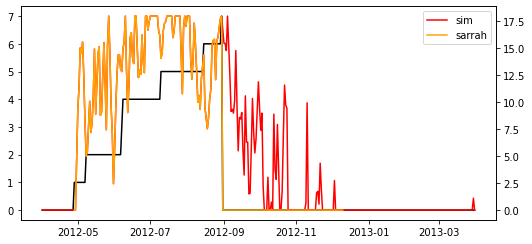

2012-08-30


/tmp/ipykernel_15004/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


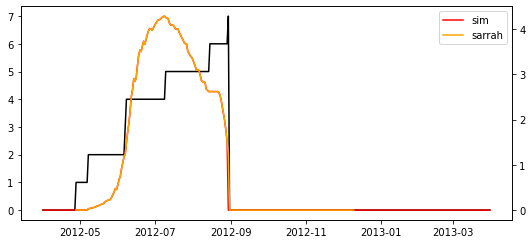

2012-08-31


/tmp/ipykernel_15004/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


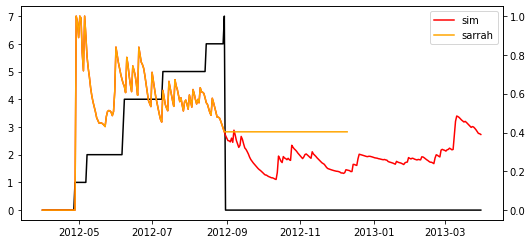

2012-08-31


/tmp/ipykernel_15004/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


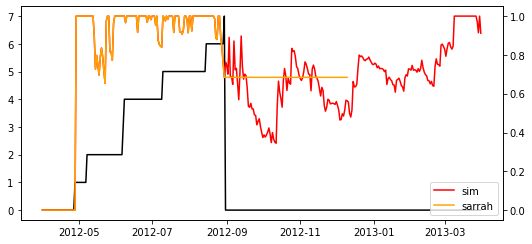

1990-01-01


/tmp/ipykernel_15004/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


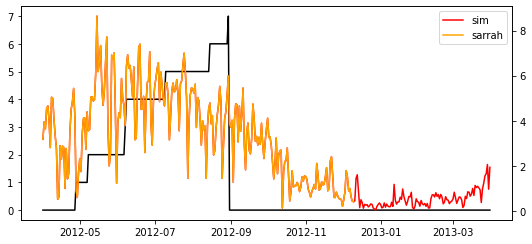

2012-08-31


/tmp/ipykernel_15004/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


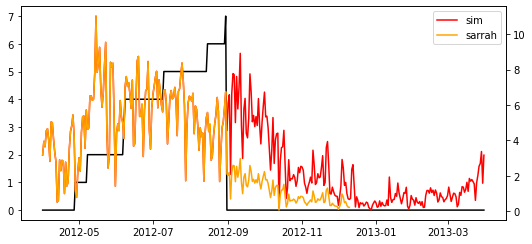

2012-08-31


/tmp/ipykernel_15004/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


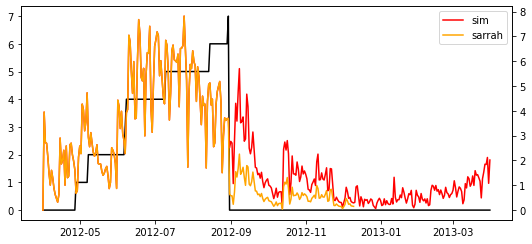

2012-08-31


/tmp/ipykernel_15004/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


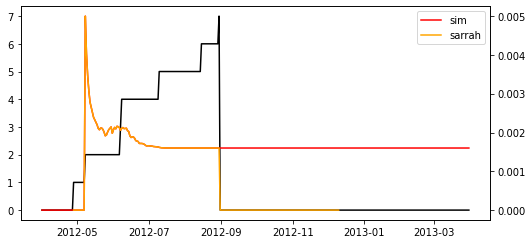

2012-08-30


/tmp/ipykernel_15004/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


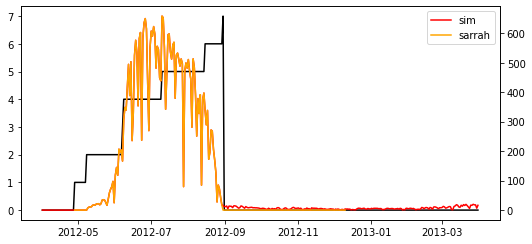

1990-01-01


/tmp/ipykernel_15004/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


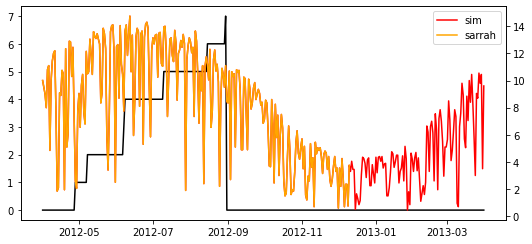

/tmp/ipykernel_15004/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


1990-01-01


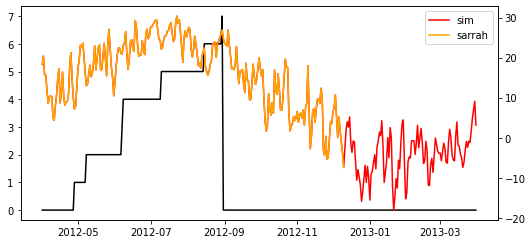

1990-01-01


/tmp/ipykernel_15004/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


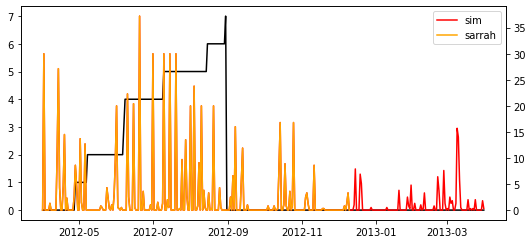

2012-08-31


/tmp/ipykernel_15004/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


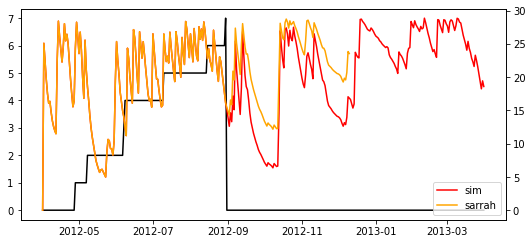

2012-08-31


/tmp/ipykernel_15004/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


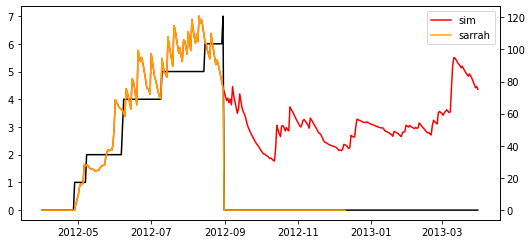

2012-08-31


/tmp/ipykernel_15004/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


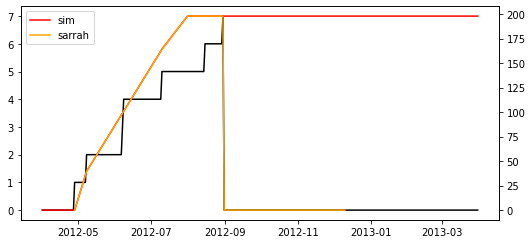

2012-08-31


/tmp/ipykernel_15004/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


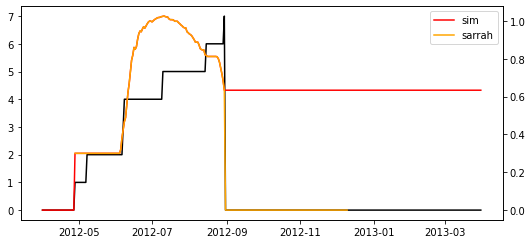

2012-09-01


/tmp/ipykernel_15004/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


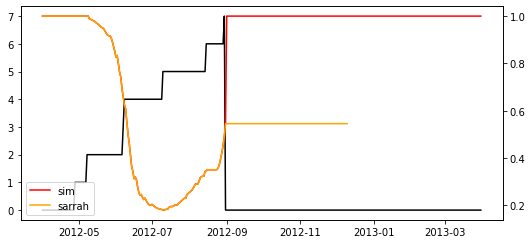

2012-09-01


/tmp/ipykernel_15004/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


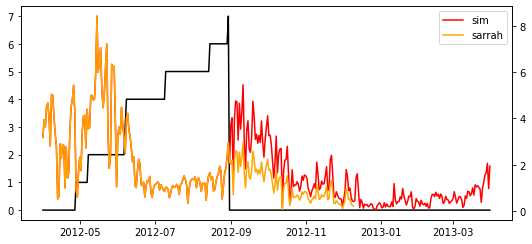

2012-09-01


/tmp/ipykernel_15004/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


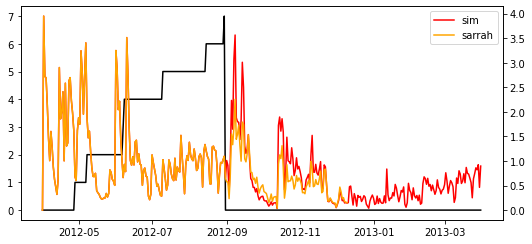

2012-08-31


/tmp/ipykernel_15004/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


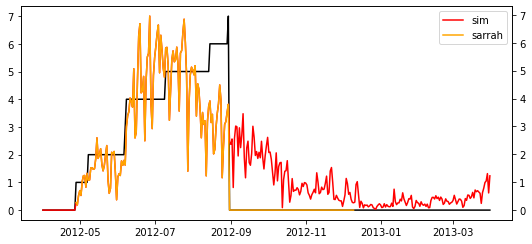

2012-08-31


/tmp/ipykernel_15004/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


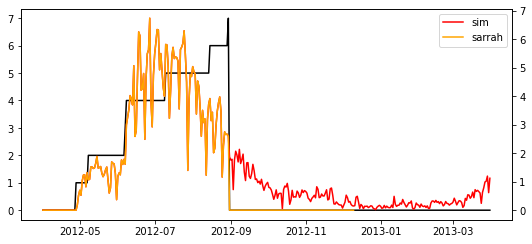

1990-01-01


/tmp/ipykernel_15004/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


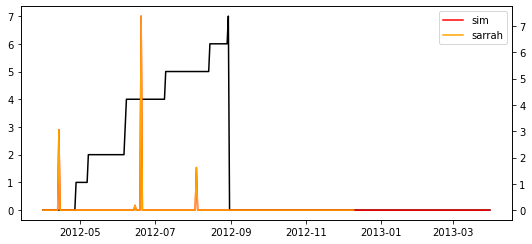

1990-01-01


/tmp/ipykernel_15004/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


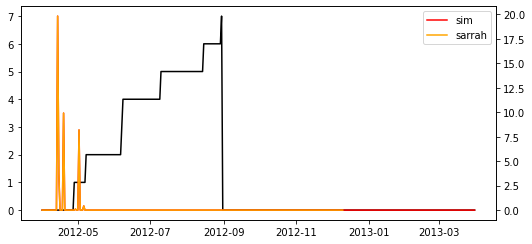

2012-08-31


/tmp/ipykernel_15004/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


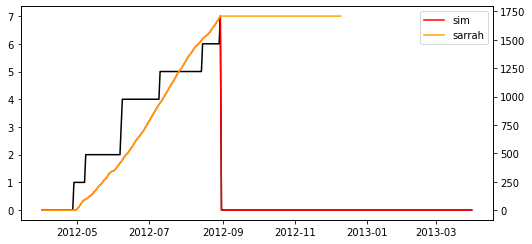

2012-08-30


/tmp/ipykernel_15004/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


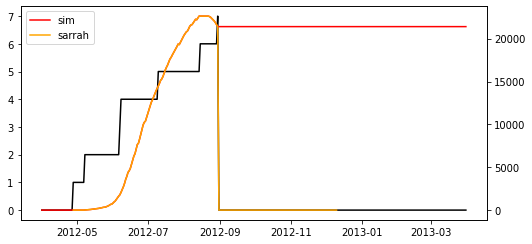

2012-08-30


/tmp/ipykernel_15004/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


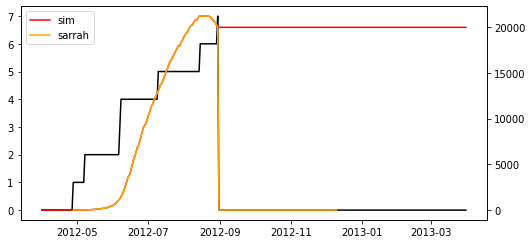

2012-08-30


/tmp/ipykernel_15004/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


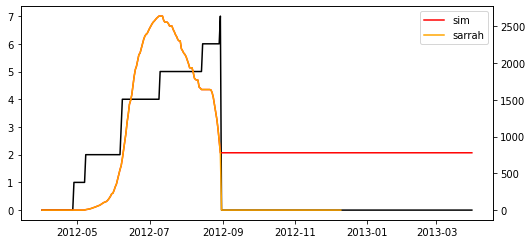

2012-08-30


/tmp/ipykernel_15004/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


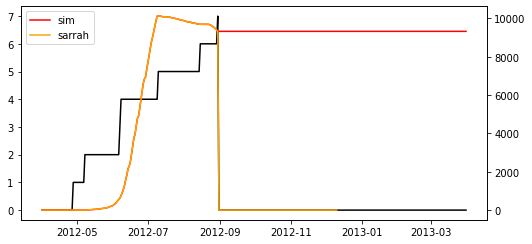

2012-08-30


/tmp/ipykernel_15004/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


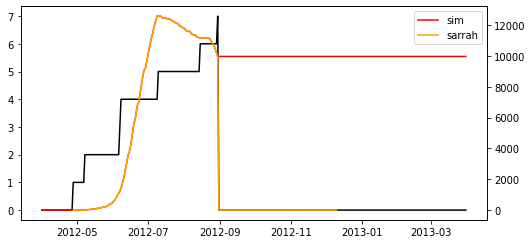

2012-08-31


/tmp/ipykernel_15004/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


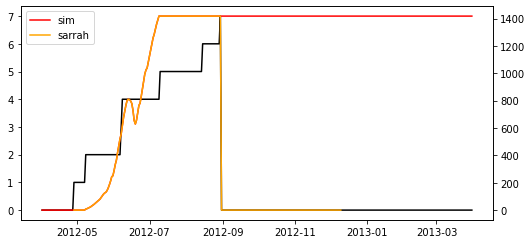

2012-08-31


/tmp/ipykernel_15004/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


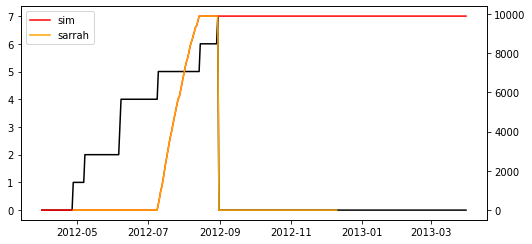

1990-01-01


/tmp/ipykernel_15004/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


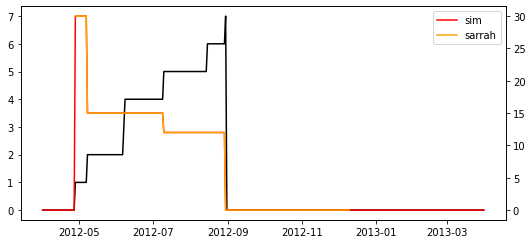

2012-09-01


/tmp/ipykernel_15004/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


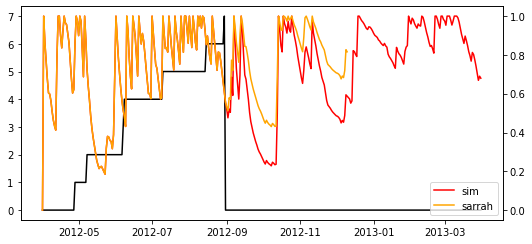

2012-08-31

/tmp/ipykernel_15004/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


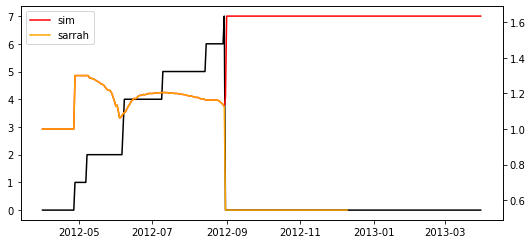

2012-08-31


/tmp/ipykernel_15004/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


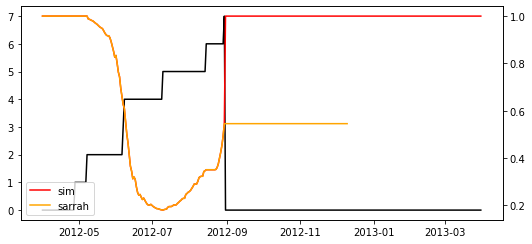

2012-08-31


/tmp/ipykernel_15004/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


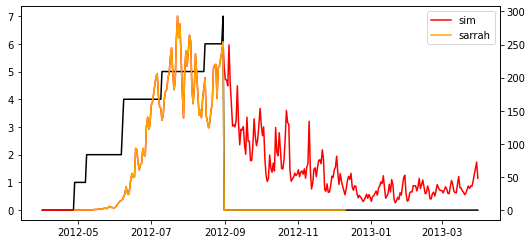

2012-08-30


/tmp/ipykernel_15004/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


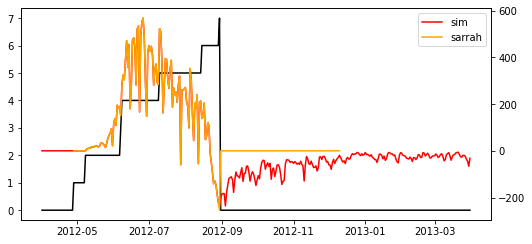

2012-08-15


/tmp/ipykernel_15004/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


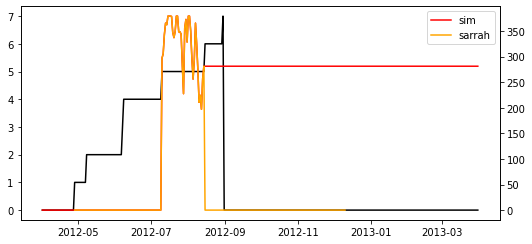

1990-01-01


/tmp/ipykernel_15004/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


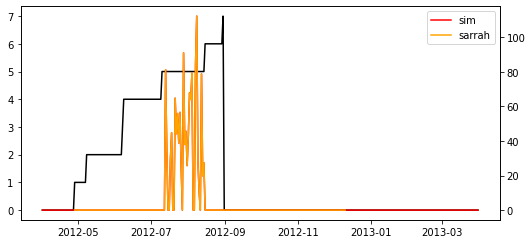

2012-08-31


/tmp/ipykernel_15004/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


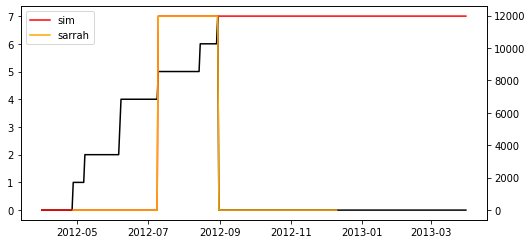

1990-01-01


/tmp/ipykernel_15004/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


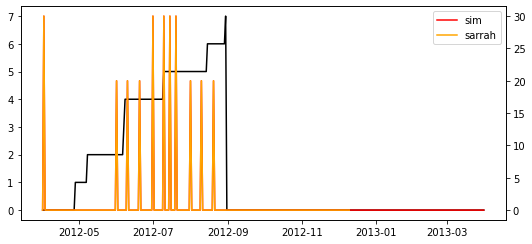

2012-08-30


/tmp/ipykernel_15004/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


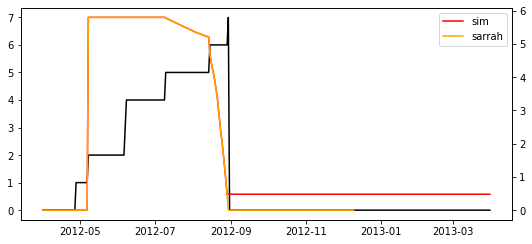

2012-08-31


/tmp/ipykernel_15004/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


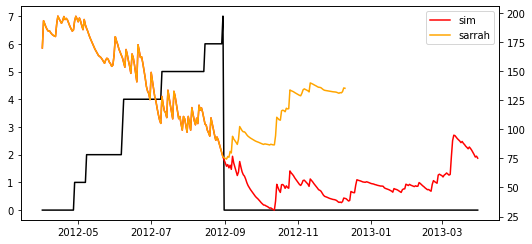

1990-01-01


/tmp/ipykernel_15004/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


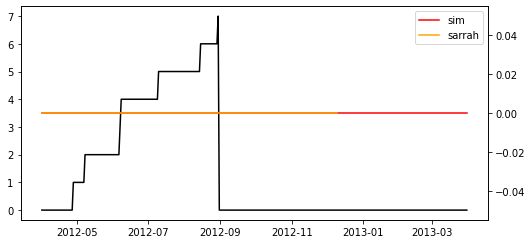

/tmp/ipykernel_15004/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


1990-01-01


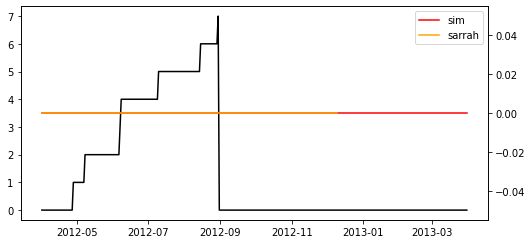

nan
nan
nan
nan
2012-09-05


/tmp/ipykernel_15004/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))
/tmp/ipykernel_15004/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))
/tmp/ipykernel_15004/1212108693.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))
/tmp/ipykernel_15004/1212108693.py:9: FutureWarning: The frame.append method is deprecated 

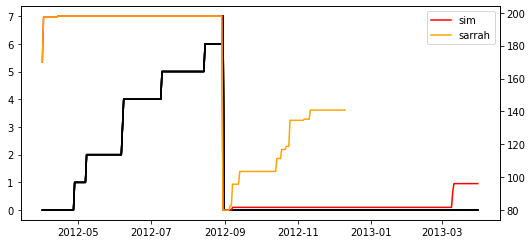

In [20]:
diff = pd.DataFrame()

for var in var_correspondance :
    try:
        # print(var,var_correspondance[var])
        
        date, meandiff = compute_earliest_diff(var, var_correspondance[var])
        print(date)
        diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))
        try:
            graph_comparison(var, var_correspondance[var])
        except:
            pass
    except:
        print(var,'failed')
        pass

In [13]:
diff.sort_values(by="earliest_diff")

,var,var2,earliest_diff,meandiff
0,Dr,dr,1990-01-01,4.482963e-16
0,StockMc,stockMc,1990-01-01,0.000000e+00
0,BiomMc,biomMc,1990-01-01,0.000000e+00
0,Lr,lr,1990-01-01,6.010066e-18
0,Eto,ET0,1990-01-01,0.000000e+00
0,VitesseRacinaire,vRac,1990-01-01,0.000000e+00
0,IrrigTotDay,irrigTotDay,1990-01-01,0.000000e+00
0,Reallocation,reallocation,1990-01-01,2.900861e-14
0,EauDispo,eauDispo,1990-01-01,1.398706e-17
0,Par,par,1990-01-01,0.000000e+00
